# Linear Regression with Db2 Stored Procedures

## Contents:
* [1. Introduction](#Introduction)
* [2. Libraries and Modules](#Libraries-and-Modules)
* [3. Connect to Db2](#Connect-to-Db2)
* [4. Data exploration](#Data-exploration)
* [5. Train/Test Split](#Train/Test-Split)
* [6. Data transformation](#Data-transformation-after-Train/Test-Split)
* [7. Train a linear regression model](#Train-a-linear-regression-model)
* [8. Predict purchase amount for train and test data](#Predict-sale-prices-for-test-data)
* [9. Evaluate Model Performance](#Evaluate-Model-Performance)

# 1. Introduction <a class="anchor" id="Introduction"></a>

Historical customer data for a fictional outdoor equipment store is used in IBM offering tutorials to train the machine learning models. The sample data is structured in rows and columns.

**Feature columns**

Feature columns are columns that contain the attributes on which the machine learning model will base predictions. In this historical data, there are four feature columns:

GENDER: Customer gender

AGE: Customer age

MARITAL_STATUS: "Married", "Single", or "Unspecified"

PROFESSION: General category of the customer's profession, such "Hospitality" or "Sales", or simply "Other"

IS_TENT: Whether or not the customer bought a tent

PRODUCT_LINE: The product category in which the customer has been most interested

**Label column**

PURCHASE_AMOUNT: The average amount of money the customer has spent on each visit to the store


Link: https://dataplatform.cloud.ibm.com/exchange/public/entry/view/aa07a773f71cf1172a349f33e2028e4e

# 2. Libraries and Modules <a class="anchor" id="Libraries-and-Modules"></a>

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../lib/'))
if module_path not in sys.path:
    sys.path.append(module_path)
import ibm_db
import ibm_db_dbi
# import ibm_db_sa
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from InDBMLModules import col_to_row_organize, print_multi_result_set, connect_to_db,\
                            close_connection_to_db, drop_object, plot_histogram, plot_barchart,\
                            null_impute_most_freq, null_impute_mean, plot_pred_act
%load_ext autoreload
%autoreload 2

# 3. Connect to Db2 <a class="anchor" id="Connect-to-Db2"></a>

In [3]:
conn_str = "DATABASE=in_db;" + \
           "HOSTNAME=*********************;"+ \
           "PROTOCOL=TCPIP;"  + \
           "PORT=*******;" + \
           "UID=***;" + \
           "PWD=******************;"

In [4]:
ibm_db_conn, ibm_db_dbi_conn = connect_to_db(conn_str, verbose=True)
rc = close_connection_to_db(ibm_db_conn, verbose=True)

Connected to the database!
Connection is closed.


# 4. Data exploration <a class="anchor" id="Data-exploration"></a>

## Create a special schema for this experiment 

In [5]:
ibm_db_conn, ibm_db_dbi_conn = connect_to_db(conn_str, verbose=False)

drop_object("LINREG", "SCHEMA", ibm_db_conn, verbose = True)
sql ="create schema LINREG authorization MLP"
stmt = ibm_db.exec_immediate(ibm_db_conn, sql)
print("Schema LINREG was created.")

rc = close_connection_to_db(ibm_db_conn, verbose=False)

Pre-existing SCHEMA LINREG was not found.
Schema LINREG was created.


## Collect statistics on the entire dataset by creating the column properties table

In [6]:
ibm_db_conn, ibm_db_dbi_conn = connect_to_db(conn_str, verbose=False)

drop_object("LINREG.GS_COL_PROP", "TABLE", ibm_db_conn, verbose = True)
sql = """CALL IDAX.COLUMN_PROPERTIES('intable=DATA.GO_SALES, outtable=LINREG.GS_COL_PROP, withstatistics=true, incolumn=ID:id; PURCHASE_AMOUNT:target')"""
stmt = ibm_db.exec_immediate(ibm_db_conn, sql)
print("TABLE LINREG.GS_COL_PROP was created.")

rc = close_connection_to_db(ibm_db_conn, verbose=False)

Pre-existing TABLE LINREG.GS_COL_PROP was not found.
TABLE LINREG.GS_COL_PROP was created.


## List columns with any nulls

In [7]:
ibm_db_conn, ibm_db_dbi_conn = connect_to_db(conn_str, verbose=False)

sql = "select COLNO, NAME, TYPE,NUMMISSING,NUMMISSING+NUMINVALID+NUMVALID as ALL_VALUES, dec(NUMMISSING,10,2)/(dec(NUMMISSING, 10,2)+dec(NUMINVALID, 10,2)+dec(NUMVALID, 10,2))*100 as NULL_PERCENTAGE from LINREG.GS_COL_PROP where NUMMISSING > 0"
GS_NULL_PREC = pd.read_sql(sql,ibm_db_dbi_conn)
print("Column properties table fetched successfully!")
    
rc = close_connection_to_db(ibm_db_conn, verbose=False)
GS_NULL_PREC.sort_values('COLNO')

Column properties table fetched successfully!


,COLNO,NAME,TYPE,NUMMISSING,ALL_VALUES,NULL_PERCENTAGE
0,1,GENDER,nom,2592,60252,4.301932
2,2,AGE,cont,2351,60252,3.901945
1,3,MARITAL_STATUS,nom,770,60252,1.277966
3,4,PROFESSION,nom,1516,60252,2.516099
4,5,IS_TENT,cont,1344,60252,2.230631
5,6,PRODUCT_LINE,nom,1977,60252,3.281219


## Evaluate CONTINIOUS columns using RUNSTATS

### Plot distribution based on runstats results

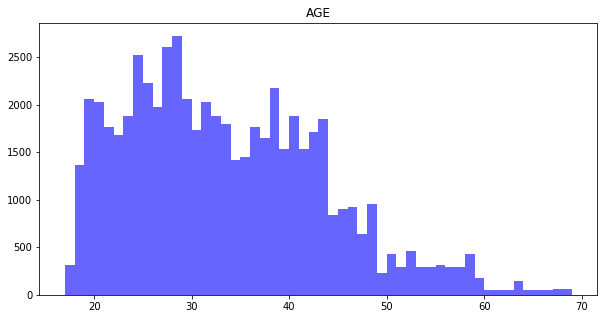

In [8]:
numerical_columns = ["AGE"]
plot_histogram (numerical_columns,"DATA","GO_SALES",conn_str)

## Evaluate NOMINAL columns using RUNSTATS

### Plot data distribution for nominal columns

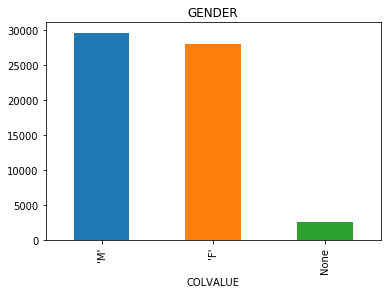

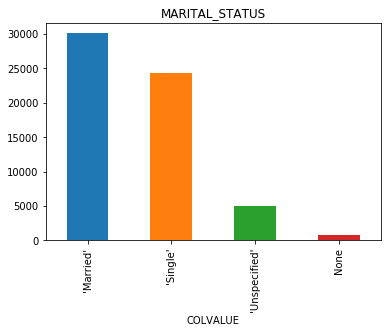

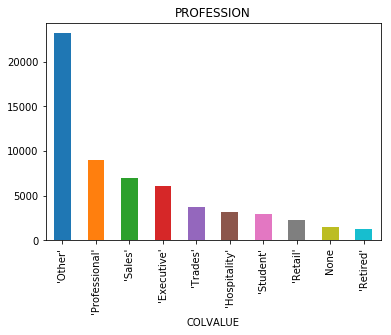

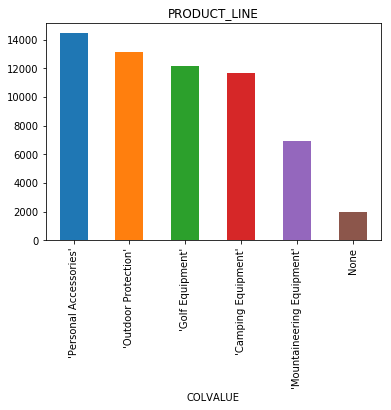

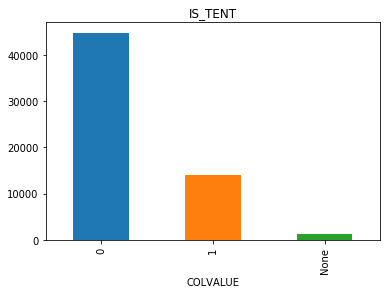

In [9]:
nominal_columns = ["GENDER","MARITAL_STATUS","PROFESSION","PRODUCT_LINE","IS_TENT"]
plot_barchart (nominal_columns, "DATA", "GO_SALES", conn_str)

## Check data skewness using SUMMARY1000 stored procedure

In [10]:
#  Create HOUSING_PRICES_SUM1000 table that contains whole dataset feature stats (mean, stdev, freq, etc)
ibm_db_conn, ibm_db_dbi_conn = connect_to_db(conn_str, verbose=False)

drop_object("LINREG.GO_SALES_SUM1000", "TABLE", ibm_db_conn, verbose = True)
drop_object("LINREG.GO_SALES_SUM1000_CHAR", "TABLE", ibm_db_conn, verbose = True)
drop_object("LINREG.GO_SALES_SUM1000_NUM", "TABLE", ibm_db_conn, verbose = True)

sql = "CALL IDAX.SUMMARY1000('intable=DATA.GO_SALES,outtable=LINREG.GO_SALES_SUM1000')"
stmt = ibm_db.exec_immediate(ibm_db_conn, sql)
print("SUM1000 tables were created.")

sql = "select * from LINREG.GO_SALES_SUM1000_NUM"
GO_SALES_SUM1000_NUM = pd.read_sql(sql,ibm_db_dbi_conn)

rc = close_connection_to_db(ibm_db_conn, verbose=False)

GO_SALES_SUM1000_NUM[["COLUMNNAME", "SKEWNESS"]]

Pre-existing TABLE LINREG.GO_SALES_SUM1000 was not found.
Pre-existing TABLE LINREG.GO_SALES_SUM1000_CHAR was not found.
Pre-existing TABLE LINREG.GO_SALES_SUM1000_NUM was not found.
SUM1000 tables were created.


,COLUMNNAME,SKEWNESS
0,AGE,6.534789e-01
1,ID,-3.414794e-14
2,IS_TENT,1.135574e+00
3,PURCHASE_AMOUNT,-7.997931e-02


**Observation:**

SKEWNESS on numerical columns is negligible.

# 5. Train/Test Split<a class="anchor" id="Train/Test-Split"></a>

In [11]:
ibm_db_conn, ibm_db_dbi_conn = connect_to_db(conn_str, verbose=False)

drop_object("LINREG.GSTRAIN", "TABLE", ibm_db_conn, verbose = True)
drop_object("LINREG.GSTEST", "TABLE", ibm_db_conn, verbose = True)

sql = "CALL IDAX.SPLIT_DATA('intable = DATA.GO_SALES, id = ID, traintable = LINREG.GSTRAIN, testtable = LINREG.GSTEST, fraction=0.8, seed=1')"
stmt = ibm_db.exec_immediate(ibm_db_conn, sql)
print("Dataset splitting was successful!")

rc = close_connection_to_db(ibm_db_conn, verbose=False)

Pre-existing TABLE LINREG.GSTRAIN was not found.
Pre-existing TABLE LINREG.GSTEST was not found.
Dataset splitting was successful!


# 6. Data transformation<a class="anchor" id="Data-transformation-after-Train/Test-Split"></a>

## Get statistics of the train data to be used for transforming the test data

### Create the SUMMARY1000 table for training dataset

In [12]:
ibm_db_conn, ibm_db_dbi_conn = connect_to_db(conn_str, verbose=False)

drop_object("LINREG.GSTRAIN_STATS", "TABLE", ibm_db_conn, verbose = True)
drop_object("LINREG.GSTRAIN_STATS_NUM", "TABLE", ibm_db_conn, verbose = True)
drop_object("LINREG.GSTRAIN_STATS_CHAR", "TABLE", ibm_db_conn, verbose = True)    
    
sql = """CALL IDAX.SUMMARY1000('intable=LINREG.GSTRAIN,outtable=LINREG.GSTRAIN_STATS')"""
stmt = ibm_db.exec_immediate(ibm_db_conn, sql)
print("LINREG.GSTRAIN_STATS, LINREG.GSTRAIN_STATS_NUM, and LINREG.GSTRAIN_STATS_CHAR were created")

rc = close_connection_to_db(ibm_db_conn, verbose=False)

Pre-existing TABLE LINREG.GSTRAIN_STATS was not found.
Pre-existing TABLE LINREG.GSTRAIN_STATS_NUM was not found.
Pre-existing TABLE LINREG.GSTRAIN_STATS_CHAR was not found.
LINREG.GSTRAIN_STATS, LINREG.GSTRAIN_STATS_NUM, and LINREG.GSTRAIN_STATS_CHAR were created


## Null imputation

### Null impute NUMERICAL columns in TRAINING data with mean

In [13]:
ibm_db_conn, ibm_db_dbi_conn = connect_to_db(conn_str, verbose=False)
   
sql = """CALL IDAX.IMPUTE_DATA('intable=LINREG.GSTRAIN,method=mean,inColumn=AGE');"""
stmt = ibm_db.exec_immediate(ibm_db_conn, sql)
print("AGE in LINREG.GSTRAIN null imputed successfully!")
    
rc = close_connection_to_db(ibm_db_conn, verbose=False)

AGE in LINREG.GSTRAIN null imputed successfully!


### Null impute the NOMINAL columns in TRAINING with the most frequent value

In [14]:
ibm_db_conn, ibm_db_dbi_conn = connect_to_db(conn_str, verbose=False)

for column in nominal_columns:
    null_impute_most_freq ("LINREG", "GSTRAIN", column, "GSTRAIN_STATS",ibm_db_conn, verbose=True)

rc = close_connection_to_db(ibm_db_conn, verbose=False)

GENDER in LINREG.GSTRAIN null imputed successfully!
MARITAL_STATUS in LINREG.GSTRAIN null imputed successfully!
PROFESSION in LINREG.GSTRAIN null imputed successfully!
PRODUCT_LINE in LINREG.GSTRAIN null imputed successfully!
IS_TENT in LINREG.GSTRAIN null imputed successfully!


### Null impute NUMERICAL column in TEST data with mean

In [15]:
ibm_db_conn, ibm_db_dbi_conn = connect_to_db(conn_str, verbose=False)

for column in numerical_columns:
    null_impute_mean("LINREG", "GSTEST", column, "GSTRAIN_STATS",ibm_db_conn, verbose=True)

rc = close_connection_to_db(ibm_db_conn, verbose=False)

AGE in LINREG.GSTEST null imputed successfully!


### Null impute the NOMINAL columns in TEST data with the most frequent value

In [16]:
ibm_db_conn, ibm_db_dbi_conn = connect_to_db(conn_str, verbose=False)

for column in nominal_columns:
    null_impute_most_freq ("LINREG", "GSTEST", column, "GSTRAIN_STATS",ibm_db_conn, verbose=True)
    
rc = close_connection_to_db(ibm_db_conn, verbose=False)

GENDER in LINREG.GSTEST null imputed successfully!
MARITAL_STATUS in LINREG.GSTEST null imputed successfully!
PROFESSION in LINREG.GSTEST null imputed successfully!
PRODUCT_LINE in LINREG.GSTEST null imputed successfully!
IS_TENT in LINREG.GSTEST null imputed successfully!


## Standardize AGE in training data

In [17]:
ibm_db_conn, ibm_db_dbi_conn = connect_to_db(conn_str, verbose=False)

drop_object("LINREG.GSTRAIN_STD", "TABLE", ibm_db_conn, verbose = True)
    
sql = """CALL IDAX.STD_NORM('intable=LINREG.GSTRAIN, 
        incolumn="GENDER":L;"AGE":S;"MARITAL_STATUS":L;"PROFESSION":L;"IS_TENT":L;"PRODUCT_LINE":L;"PURCHASE_AMOUNT":L, 
        id=ID, outtable=LINREG.GSTRAIN_STD');"""
stmt = ibm_db.exec_immediate(ibm_db_conn, sql)
print("LINREG.GSTRAIN_STD was created and AGE column was standardized.")
    
rc = close_connection_to_db(ibm_db_conn, verbose=False)

Pre-existing TABLE LINREG.GSTRAIN_STD was not found.
LINREG.GSTRAIN_STD was created and AGE column was standardized.


## Standardize AGE in test data

In [18]:
ibm_db_conn, ibm_db_dbi_conn = connect_to_db(conn_str, verbose=False)

drop_object("LINREG.GSTEST_STD", "TABLE", ibm_db_conn, verbose = True)
    
sql = "CREATE TABLE LINREG.GSTEST_STD AS (SELECT * FROM LINREG.GSTEST) WITH DATA ORGANIZE BY ROW"
stmt = ibm_db.exec_immediate(ibm_db_conn, sql)
print ("Table LINREG.GSTEST_STD was created.")

sql = """UPDATE LINREG.GSTEST_STD 
        SET AGE = ((CAST(AGE AS FLOAT) - (SELECT AVERAGE FROM LINREG.GSTRAIN_STATS_NUM WHERE COLUMNNAME='AGE'))/(SELECT STDDEV FROM LINREG.GSTRAIN_STATS_NUM WHERE COLUMNNAME='AGE'))"""
stmt = ibm_db.exec_immediate(ibm_db_conn, sql)
print("AGE was standardized in test data successfully!")

#renaming AGE to STD_AGE
sql = """ALTER TABLE LINREG.GSTEST_STD RENAME COLUMN AGE TO STD_AGE"""
stmt = ibm_db.exec_immediate(ibm_db_conn, sql)

rc = close_connection_to_db(ibm_db_conn, verbose=False)

Pre-existing TABLE LINREG.GSTEST_STD was not found.
Table LINREG.GSTEST_STD was created.
AGE was standardized in test data successfully!


# 7. Train a linear regression model<a class="anchor" id="Train-a-linear-regression-model"></a>

## Train the model

In [19]:
ibm_db_conn, ibm_db_dbi_conn = connect_to_db(conn_str, verbose=False)

drop_object("LINREG.GSLINREG", "MODEL", ibm_db_conn, verbose = True)

sql = """CALL IDAX.LINEAR_REGRESSION('model=LINREG.GSLINREG, intable=LINREG.GSTRAIN_STD, id=ID, 
        target= PURCHASE_AMOUNT, incolumn =GENDER;STD_AGE;MARITAL_STATUS;PROFESSION;IS_TENT;PRODUCT_LINE');"""
stmt = ibm_db.exec_immediate(ibm_db_conn, sql)
print("Model trained successfully!")

rc = close_connection_to_db(ibm_db_conn, verbose=False)

Pre-existing MODEL LINREG.GSLINREG was not found.
Model trained successfully!


# 8. Predict purchase amount for train and test data<a class="anchor" id="Predict-sale-prices-for-test-data"></a>

## Create view GSTEST_INPUT from feature columns in GSTEST_STD

In [21]:
ibm_db_conn, ibm_db_dbi_conn = connect_to_db(conn_str, verbose=False)

drop_object("LINREG.GSTEST_INPUT", "VIEW", ibm_db_conn, verbose = True)

sql = "CREATE VIEW LINREG.GSTEST_INPUT AS (SELECT ID,GENDER,STD_AGE,MARITAL_STATUS,PROFESSION,IS_TENT,PRODUCT_LINE FROM LINREG.GSTEST_STD)"
stmt = ibm_db.exec_immediate(ibm_db_conn, sql)
print("VIEW LINREG.GSTEST_INPUT was created successfuly!")

rc = close_connection_to_db(ibm_db_conn, verbose=False)

Pre-existing VIEW LINREG.GSTEST_INPUT was not found.
VIEW LINREG.GSTEST_INPUT was created successfuly!


## Predict purchase amounts using IDAX.PREDICT_LINEAR_REGRESSION 

In [22]:
ibm_db_conn, ibm_db_dbi_conn = connect_to_db(conn_str, verbose=False)

drop_object("LINREG.GSTEST_OUTPUT", "TABLE", ibm_db_conn, verbose = True)
        
sql = """CALL IDAX.PREDICT_LINEAR_REGRESSION('model=LINREG.GSLINREG, intable=LINREG.GSTEST_INPUT, outtable =LINREG.GSTEST_OUTPUT, id=ID')"""
stmt = ibm_db.exec_immediate(ibm_db_conn, sql)
print("LINREG.GSTEST_OUTPUT was created with test results.")

rc = close_connection_to_db(ibm_db_conn, verbose=False)

Pre-existing TABLE LINREG.GSTEST_OUTPUT was not found.
LINREG.GSTEST_OUTPUT was created with test results.


## Create view GSTRAIN_INPUT from feature columns in GSTRAIN_STD

In [23]:
ibm_db_conn, ibm_db_dbi_conn = connect_to_db(conn_str, verbose=False)

drop_object("LINREG.GSTRAIN_INPUT", "VIEW", ibm_db_conn, verbose = True)

sql = "CREATE VIEW LINREG.GSTRAIN_INPUT AS (SELECT ID,GENDER,STD_AGE,MARITAL_STATUS,PROFESSION,IS_TENT,PRODUCT_LINE FROM LINREG.GSTRAIN_STD)"
stmt = ibm_db.exec_immediate(ibm_db_conn, sql)
print("VIEW LINREG.GSTRAIN_INPUT was created successfuly!")

rc = close_connection_to_db(ibm_db_conn, verbose=False)

Pre-existing VIEW LINREG.GSTRAIN_INPUT was not found.
VIEW LINREG.GSTRAIN_INPUT was created successfuly!


## Predict purchase amounts using IDAX.PREDICT_LINEAR_REGRESSION 

In [24]:
ibm_db_conn, ibm_db_dbi_conn = connect_to_db(conn_str, verbose=False)

drop_object("LINREG.GSTRAIN_OUTPUT", "TABLE", ibm_db_conn, verbose = True)
        
sql = """CALL IDAX.PREDICT_LINEAR_REGRESSION('model=LINREG.GSLINREG, intable=LINREG.GSTRAIN_INPUT, outtable =LINREG.GSTRAIN_OUTPUT, id=ID')"""
stmt = ibm_db.exec_immediate(ibm_db_conn, sql)
print("LINREG.GSTEST_OUTPUT was created with train results.")

rc = close_connection_to_db(ibm_db_conn, verbose=False)

Pre-existing TABLE LINREG.GSTRAIN_OUTPUT was not found.
LINREG.GSTEST_OUTPUT was created with train results.


# 9. Evaluate Model Performance<a class="anchor" id="Evaluate-Model-Performance"></a>

## Evaluate model performance on TRAINING data

In [25]:
ibm_db_conn, ibm_db_dbi_conn = connect_to_db(conn_str, verbose=False)

print("Training performance: ")
sql = """CALL IDAX.MSE('intable= LINREG.GSTRAIN_STD, id = ID, target = PURCHASE_AMOUNT, resulttable=LINREG.GSTRAIN_OUTPUT, resultid=ID, resulttarget=PURCHASE_AMOUNT')"""
print_multi_result_set(ibm_db_conn, sql)
sql = """CALL IDAX.MAE('intable= LINREG.GSTRAIN_STD, id = ID, target = PURCHASE_AMOUNT, resulttable=LINREG.GSTRAIN_OUTPUT, resultid=ID, resulttarget=PURCHASE_AMOUNT')"""
print_multi_result_set(ibm_db_conn, sql)

rc = close_connection_to_db(ibm_db_conn, verbose=False)

Training performance: 
{'MSE': 98.36862842452432}
{'MAE': 7.5297574998766}


## Evaluate model performance on TEST data

In [26]:
ibm_db_conn, ibm_db_dbi_conn = connect_to_db(conn_str, verbose=False)

print("Test performance: ")
sql = """CALL IDAX.MSE('intable= LINREG.GSTEST_STD, id = ID, target = PURCHASE_AMOUNT, resulttable=LINREG.GSTEST_OUTPUT, resultid=ID, resulttarget=PURCHASE_AMOUNT')"""
print_multi_result_set(ibm_db_conn, sql)
sql = """CALL IDAX.MAE('intable= LINREG.GSTEST_STD, id = ID, target = PURCHASE_AMOUNT, resulttable=LINREG.GSTEST_OUTPUT, resultid=ID, resulttarget=PURCHASE_AMOUNT')"""
print_multi_result_set(ibm_db_conn, sql)

rc = close_connection_to_db(ibm_db_conn, verbose=False)

Test performance: 
{'MSE': 97.53595615684684}
{'MAE': 7.461251686160011}


**Observations:**

* Mean absolute error on test data is 7.46 -> Model predicts with a fairly good accuracy.
* Performance is consistent for Training and Test datasets -> Model is not overfitting the training set.

## Visually evaluate model performance

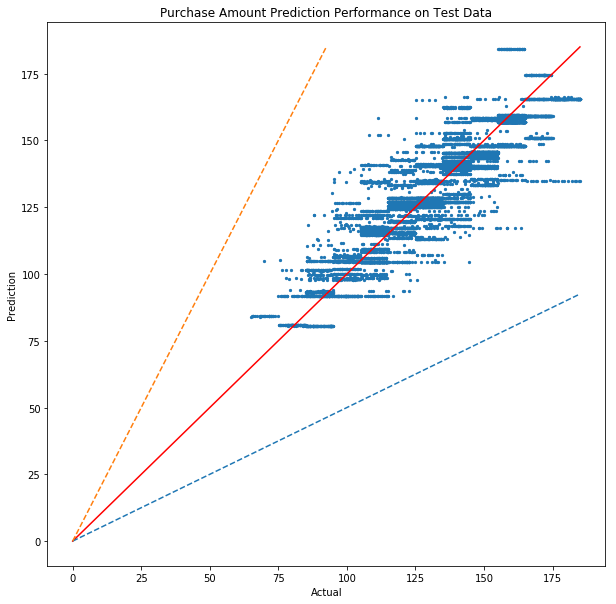

In [27]:
ibm_db_conn, ibm_db_dbi_conn = connect_to_db(conn_str, verbose=False)

sql = """select ACT.ID, ACT.PURCHASE_AMOUNT AS ACTUAL, PRED.PURCHASE_AMOUNT AS PREDICTION
            from LINREG.GSTEST_STD AS ACT, LINREG.GSTEST_OUTPUT AS PRED
            where ACT.ID = PRED.ID"""
GSTEST_ACT_PRED = pd.read_sql(sql,ibm_db_dbi_conn)
    
rc = close_connection_to_db(ibm_db_conn, verbose=False)

act = GSTEST_ACT_PRED.ACTUAL.values
pred = GSTEST_ACT_PRED.PREDICTION.values
plot_pred_act(pred,act,"Purchase Amount Prediction Performance on Test Data", "Actual", "Prediction")